In [1]:
import pandas as pd
import os
import shutil

def get_result(n_station, inst_no, rpm, ratio, time_budget):
    for i in range(1, 2):
        obj_20_runs = []
        time_20_runs = []
        dissat_20_runs = []
        emission_20_runs = []
        ratio = f"{float(ratio):.2f}"
        file_name= f"Solutions/2024-09-14/{n_station}_{inst_no}_t2_r{rpm}_p{ratio}0000_{time_budget}h_{i}.txt"
        with open(file_name, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith("individual's fitness value"):
                    obj_val = float(line.split(": ")[1])
                    obj_20_runs.append(obj_val)
                if line.startswith("CPU time"):
                    time = float(line.split(": ")[1])
                    time_20_runs.append(time)
                if line.startswith("individual's dissat value"):
                    dissat = float(line.split(": ")[1])
                    dissat_20_runs.append(dissat)
                if line.startswith("individual's emission value"):
                    emission = float(line.split(": ")[1])
                    emission_20_runs.append(emission)
        # find the best solution among 20 runs
        obj_val = sum(obj_20_runs) / len(obj_20_runs)
        time = sum(time_20_runs) / len(time_20_runs)
        dissat = sum(dissat_20_runs) / len(dissat_20_runs)
        emission = sum(emission_20_runs) / len(emission_20_runs)

    return obj_val, time, dissat, emission

In [2]:
n_station_list = [60, 90, 120, 200, 300, 400, 500]

final_result = dict()

for n_station in n_station_list:

    trk_list = [1,2] if n_station >= 60 else [1]
    rpm_list = [1,2] if n_station >= 60 else [1]

    for inst in range(1,2):
        for trk in trk_list:
            for rpm in rpm_list:
                obj_val_list = []
                time_list = []
                file_indices = []
                for i in range(1, 101):
                    file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{i}.txt"
                    if not os.path.exists(file_name):
                        continue
                    obj_val, time = get_result(file_name)
                    obj_val_list.append(obj_val)
                    time_list.append(time)
                    file_indices.append(i)
                df = pd.DataFrame({"obj_val": obj_val_list, "time": time_list, "index": file_indices})
                df = df.sort_values(by="obj_val")
                best_obj_val = df["obj_val"].head(20).mean()
                best_obj_best = df["obj_val"].head(20).min()
                best_time = df["time"].head(20).mean()
                best_std = df["obj_val"].head(20).std()
                final_result[f"{n_station}_{inst}_{trk}_{rpm}"] = {"best_obj_val": best_obj_val, "best_obj_best": best_obj_best,
                "best_time": best_time, "best_std": best_std}
                
                # Track the indices of the top 20 results
                top_20_indices = df["index"].head(20).tolist()
                
                # Preserve and renumber the top 20 files
                for new_index, old_index in enumerate(top_20_indices, start=1):
                    old_file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{old_index}.txt"
                    new_file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{new_index}.txt"
                    if old_file_name != new_file_name: 
                        shutil.copyfile(old_file_name, new_file_name)
                
                # Remove other files
                for i in range(1, 101):
                    if i > 20:
                        file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{i}.txt"
                        if os.path.exists(file_name):
                            os.remove(file_name)

                # Rename the top 20 files to 1, 2, 3, ..., 20


df = pd.DataFrame(final_result).T
df.index = df.index.astype(str)
split_index = df.index.str.split("_", expand=True)
split_index_df = pd.DataFrame(split_index.tolist(), index=df.index, columns=["n_station", "inst", "trk", "rpm"])

df[["n_station", "inst", "trk", "rpm"]] = split_index_df

df = df[["n_station", "inst", "trk", "rpm", "best_obj_val", "best_obj_best", "best_time", "best_std"]]

df.set_index(["n_station", "inst", "trk", "rpm"], inplace=True)

df = df.round(2)

df

best_obj_val  best_obj_best  best_time  best_std
n_station inst trk rpm                                                  
60        1    1   1         1031.72        1025.11       8.68      3.21
                   2          984.35         966.86      12.05      7.44
               2   1          944.78         918.45      11.46      7.78
                   2          905.04         896.28      13.03      5.15
90        1    1   1         3905.07        3865.03      10.71     17.24
                   2         3781.92        3735.60      14.12     19.15
               2   1         3707.17        3652.58      14.04     21.23
                   2         3608.64        3563.30      19.14     22.35
120       1    1   1         4205.12        4180.03       8.77     10.70
                   2         4108.32        4087.78      18.30      9.57
               2   1         4027.26        4007.56      14.08     11.70
                   2         3956.90        3909.70      17.10     15.59
200       1    1   1         7695.87        7636.22      14.54     22.64
                   2         7576.42        7539.85      25.16     14.91
               2   1         7473.85        7406.93      20.49     33.88
                   2         7398.57        7333.03      27.86     28.95
300       1    1   1        11027.51       10973.30      19.05     23.91
                   2        10901.78       10858.60      37.56     17.86
               2   1        10831.40       10756.00      25.91     24.65
                   2        10699.11       10638.50      44.37     24.60
400       1    1   1        14142.08       14090.00      22.39     21.12
                   2        14009.83       13974.40      44.62     15.84
               2   1        13971.24       13926.70      32.93     20.40
                   2        13853.31       13822.50      58.83     14.53
500       1    1   1        18823.05       18716.10      21.78     36.57
                   2        18598.11       18539.40      56.75     27.57
               2   1        18575.65       18493.30      34.88     40.59
                   2        18408.42       18250.20      60.70     45.66

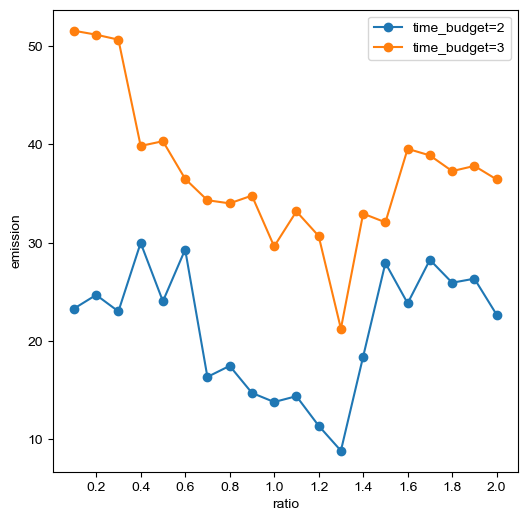

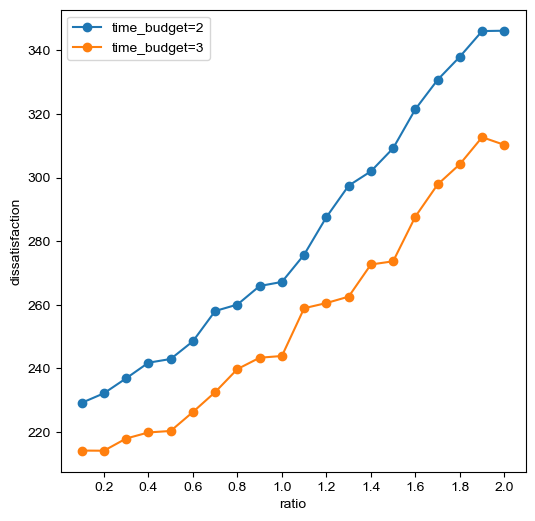

In [80]:
from matplotlib import pyplot as plt
# font Arial
plt.rcParams["font.family"] = "Arial"
n_station = 30
inst_no = 1001
results_time = dict()
results_rpm = dict()
rpm_list = [1,2]
tb_list = [2,3]
# ratio rng 0.1 to 2.0 with 0.1 step
ratio_rng = [0.1 * i for i in range(1,21)]
# ratio_rng = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# ratio_rng = [0.05 * i for i in range(1, 41)]
# ratio_rng = [0.50, 0.55, 0.60÷, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45, 1.50]
for time_budget in tb_list:
    results_time[time_budget] = dict()
    for rpm in rpm_list:
        if rpm not in results_rpm:
            results_rpm[rpm] = dict()
        dissats = []
        emissions = []
        obj_vals = []
        for ratio in ratio_rng:
            obj_val, time, dissat, emission = get_result(n_station, inst_no, rpm, ratio, time_budget)
            dissats.append(dissat)
            emissions.append(emission)
            obj_vals.append(obj_val)
        results_time[time_budget][rpm] = {"dissats": dissats, "emissions": emissions, "obj_vals": obj_vals}
        results_rpm[rpm][time_budget] = {"dissats": dissats, "emissions": emissions, "obj_vals": obj_vals}

# two sets of plots for emission, one set is one inside each is two lines for different rpm
# the other set is one inside each is two lines for different time budget
# each set has len(rpm_list) (len(tb_list) respectively) subplots

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
# fig.suptitle(f"n_station={n_station}, inst_no={inst_no}")

axs.plot(ratio_rng, results_rpm[1][2]["emissions"], label=f"time_budget={2}", marker="o")
axs.plot(ratio_rng, results_rpm[1][3]["emissions"], label=f"time_budget={3}", marker="o")
# axs.set_title(f"rpm={rpm}")
axs.legend()
axs.set_xlabel("ratio")
axs.set_ylabel("emission")
axs.set_xticks([0.2 * i for i in range(1,11)])
axs.set_xticklabels([f"{x:.1f}" for x in [0.2 * i for i in range(1,11)]])
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(6, 6))
# fig.suptitle(f"n_station={n_station}, inst_no={inst_no}")

axs.plot(ratio_rng, results_rpm[1][2]["dissats"], label=f"time_budget={2}", marker="o")
axs.plot(ratio_rng, results_rpm[1][3]["dissats"], label=f"time_budget={3}", marker="o")
# axs.set_title(f"rpm={rpm}")
axs.legend()
axs.set_xlabel("ratio")
axs.set_ylabel("dissatisfaction")
axs.set_xticks([0.2 * i for i in range(1,11)])
axs.set_xticklabels([f"{x:.1f}" for x in [0.2 * i for i in range(1,11)]])
plt.show()



In [1]:
import numpy as np
import os

for rpm in [1, 2, 3, 4]:
    for tb in [7200, 10800, 14400, 18000]:
        for i in np.arange(0.05, 2.05, 0.05):
            # in Solutions/2024-09-14, count the number of files with the pattern f"120_1_t1_r{rpm}_p{i}0000_{tb}_*.txt"
            count = 0
            for root, dirs, files in os.walk("Solutions/2024-09-14"):
                for file in files:
                    # Format i to two decimal places
                    formatted_i = f"{i:.2f}"
                    if file.startswith(f"120_1_t1_r{rpm}_p{formatted_i}0000_{tb//3600}h_"):
                        count += 1
            if count != 20:
                print(f"rpm: {rpm}, tb: {tb}, p: {formatted_i}, count: {count}")